# TODO:

* Use whole episode as batch when learning?
* Try without gradient clipping

In [1]:
import sys
sys.path.append("..")
import models
import policy_gradient_methods
import utils
import gymnasium as gym
import torch
import random

# Settings

In [16]:
ENVIRONMENT_ID = "CartPole-v1"
NUM_EPISODES = 1000
GRAD_CLIP_VALUE = 100
GAMMA = 0.9
NN_HIDDEN_LAYER_SIZES = [16, 16]
RNG_SEED = 7
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("PyTorch device:", device)
torch.manual_seed(RNG_SEED)
random.seed(RNG_SEED)

PyTorch device: cpu


In [18]:
def select_action_softmax(model, state):
    with torch.no_grad():
        return torch.distributions.categorical.Categorical(model(state)).sample().item()

gamma = GAMMA
env = gym.make(ENVIRONMENT_ID)
policy_model = torch.nn.Sequential(
    torch.nn.Linear(env.observation_space.shape[0], env.action_space.n),
    torch.nn.Softmax(dim=0)
).to(device)

# Initiate episode
# Set seed only one time per training run. For more info, see https://gymnasium.farama.org/api/env/.
observation, info = env.reset(seed=RNG_SEED)
state = torch.tensor(observation, device=device)
truncated = False
terminated = False
G = 0
states = [state]
actions = []
rewards = []

# Generate episode
t = 0
while not (terminated or truncated) and t < 4: # TODO: REMOVE!!!!!!!!!!!!!!
    action = select_action_softmax(policy_model, state)
    observation, reward, terminated, truncated, info = env.step(action)
    next_state = torch.tensor(observation, device=device)
    states.append(next_state)
    actions.append(action)
    rewards.append(reward)
    G += reward
    state = next_state
    t += 1

# Learn from episode
returns = []
G = 0
for t in reversed(range(len(rewards))):
    G = gamma * G + rewards[t]
    returns.append(G)
    #loss = -gamma**t * G * torch.log(policy_model(states[t])[actions[t]])
print(returns)
returns.reverse()
print(returns)
print(torch.tensor(returns))
print(states)
print(torch.stack(states[], dim=0))

[1.0, 1.9, 2.71, 3.439]
[3.439, 2.71, 1.9, 1.0]
tensor([3.4390, 2.7100, 1.9000, 1.0000])
[tensor([ 0.0125,  0.0397,  0.0276, -0.0275]), tensor([ 0.0133, -0.1558,  0.0270,  0.2738]), tensor([ 0.0102, -0.3513,  0.0325,  0.5749]), tensor([ 0.0032, -0.1566,  0.0440,  0.2926]), tensor([3.0043e-05, 3.7838e-02, 4.9843e-02, 1.4091e-02])]
tensor([[ 1.2510e-02,  3.9721e-02,  2.7569e-02, -2.7479e-02],
        [ 1.3304e-02, -1.5578e-01,  2.7019e-02,  2.7377e-01],
        [ 1.0188e-02, -3.5128e-01,  3.2494e-02,  5.7485e-01],
        [ 3.1626e-03, -1.5663e-01,  4.3992e-02,  2.9258e-01],
        [ 3.0043e-05,  3.7838e-02,  4.9843e-02,  1.4091e-02]])


# REINFORCE

## Linear model

In [4]:
def select_action_softmax(model, state):
    with torch.no_grad():
        return torch.distributions.categorical.Categorical(model(state)).sample().item()

def train_episodic_reinforce(env, policy_model, optimizer, device, rng_seed, num_episodes, gamma, grad_clip_value=None):
    returns = []
    for episode in range(num_episodes):
        # Initiate episode
        # Set seed only one time per training run. For more info, see https://gymnasium.farama.org/api/env/.
        seed = rng_seed if episode == 0 else None
        observation, info = env.reset(seed=seed)
        state = torch.tensor(observation, device=device)
        truncated = False
        terminated = False
        G = 0
        states = [state]
        actions = []
        rewards = []

        # Generate episode
        while not (terminated or truncated):
            action = select_action_softmax(policy_model, state)
            observation, reward, terminated, truncated, info = env.step(action)
            next_state = torch.tensor(observation, device=device)
            states.append(next_state)
            actions.append(action)
            rewards.append(reward)
            G += reward
            state = next_state
        returns.append(G)

        # Learn from episode
        G = 0
        for t in reversed(range(len(rewards))):
            G = gamma * G + rewards[t]
            loss = -gamma**t * G * torch.log(policy_model(states[t])[actions[t]])
            optimizer.zero_grad()
            loss.backward()
            if grad_clip_value != None:
                torch.nn.utils.clip_grad_value_(policy_model.parameters(), grad_clip_value)
            optimizer.step()
        
    return returns, states, actions, rewards

Average return per episode: 46.521


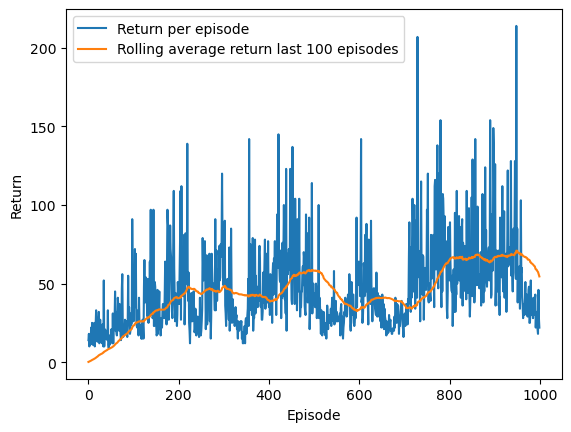

In [5]:
env = gym.make(ENVIRONMENT_ID)
policy_model = torch.nn.Sequential(
    torch.nn.Linear(env.observation_space.shape[0], env.action_space.n),
    torch.nn.Softmax(dim=0)
).to(device)
optimizer = torch.optim.SGD(policy_model.parameters(), lr=0.01)
returns, states, actions, rewards = train_episodic_reinforce(
    env, policy_model, optimizer, device, RNG_SEED, NUM_EPISODES, GAMMA, GRAD_CLIP_VALUE
)
utils.plot_returns(returns, env.spec.reward_threshold)

## Neural network model

Average return per episode: 38.802


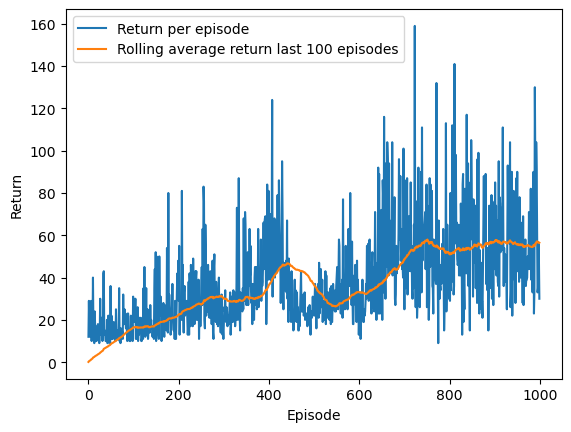

In [6]:
env = gym.make(ENVIRONMENT_ID)
policy_model = models.create_simple_nn(
    env.observation_space.shape[0],
    env.action_space.n,
    NN_HIDDEN_LAYER_SIZES,
    output_activation="softmax"
).to(device)
#optimizer = torch.optim.SGD(policy_model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(policy_model.parameters(), lr=0.001, amsgrad=True)
returns, states, actions, rewards = train_episodic_reinforce(
    env, policy_model, optimizer, device, RNG_SEED, NUM_EPISODES, GAMMA, GRAD_CLIP_VALUE
)
utils.plot_returns(returns, env.spec.reward_threshold)

# REINFORCE with baseline

## Linear model

## Neural network model